# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal data 

In [5]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-17 15:46 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-17 15:46 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-17 15:46 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-17 15:46 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-17 15:46 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-17 15:46 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-17 15:47 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-17 15:47 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-17 15:47 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [6]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')
LINKS_PATH = os.path.join(DATA_PATH, "links.csv")
TMDB_PATH = os.path.join(DATA_PATH, "tmdb.json")


In [7]:
ratings = sc.textFile(RATINGS_PATH)

In [8]:
%%time
ratings.take(5)

CPU times: user 7.31 ms, sys: 5.33 ms, total: 12.6 ms
Wall time: 2.34 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
ratings.getNumPartitions()

5

In [10]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 17.3 ms, sys: 4.94 ms, total: 22.2 ms
Wall time: 45.2 s


162541

Сохраним датасет в память

In [13]:
ratings = ratings.persist()

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 31.7 ms, sys: 19.9 ms, total: 51.6 ms
Wall time: 1min 15s


162541

Количество фильмов

In [15]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 87 ms, sys: 33.1 ms, total: 120 ms
Wall time: 21.6 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [16]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [17]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

In [18]:


movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (175077, (5.0, ['175077', 'Fatal Call (2012)'])),
 (116606, (5.0, ['116606', 'Dark Hearts (2014)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [19]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [20]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-17 15:50 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      59125 2021-02-17 15:50 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112200 2021-02-17 15:50 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131273 2021-02-17 15:50 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114154 2021-02-17 15:50 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133702 2021-02-17 15:50 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117718 2021-02-17 15:50 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143222 2021-02-17 15:50 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132134 2021-02-17 15:50 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167806 2021-02-17 15:50 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [21]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [22]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [23]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

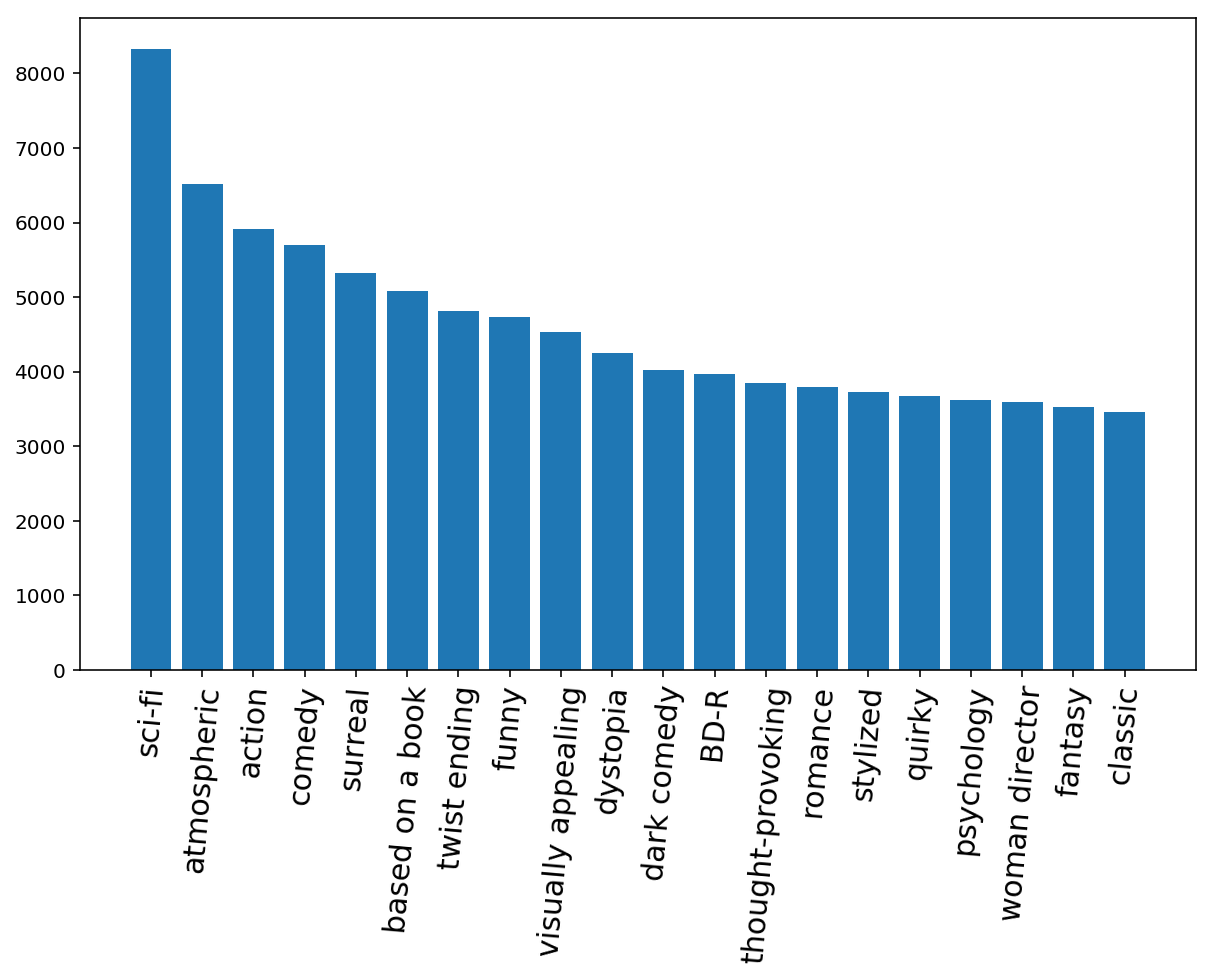

In [24]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [25]:
######################################
######### YOUR CODE HERE #############
######################################
votes = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)


In [26]:
votes \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .map(lambda a: ( a[1][1][1], a[1][0]))\
    .take(10)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [27]:
######################################
######### YOUR CODE HERE #############
######################################

fives = ratings \
    .map(lambda r: (r.movie_id, 1 if r.rating == 5 else 0)) \
    .reduceByKey(lambda a, b: a + b)


fives \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .map(lambda a: ( a[1][1][1], a[1][0]))\
    .take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

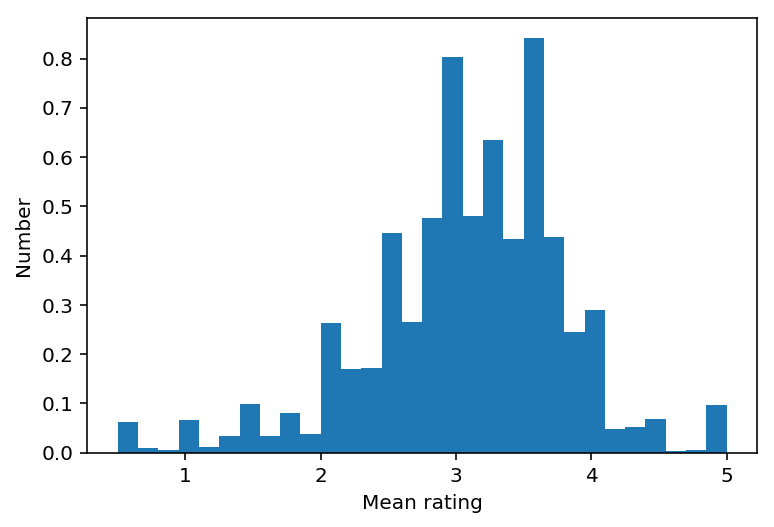

In [28]:
######################################
######### YOUR CODE HERE #############
######################################
x = movie_avg_rating.map(lambda m: m[1]).collect()
plt.hist(x, density=True, bins=30)  
plt.ylabel('Number')
plt.xlabel('Mean rating');

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

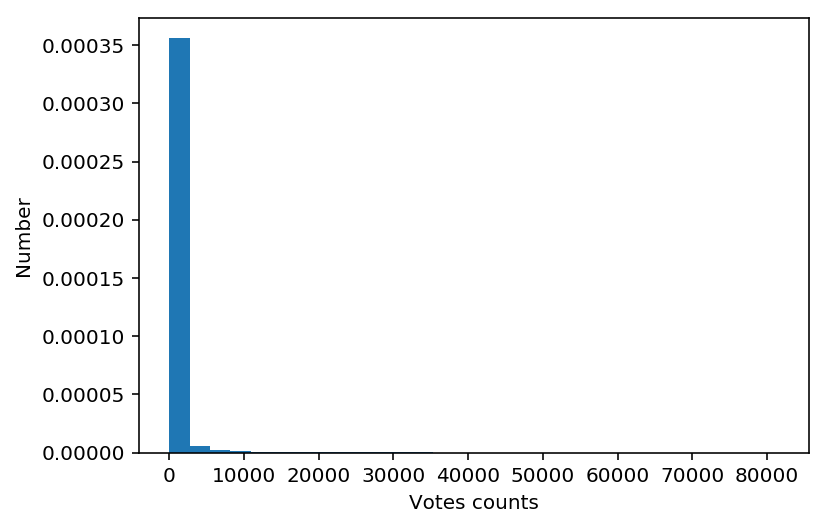

In [29]:
######################################
######### YOUR CODE HERE #############
######################################
x = votes.map(lambda m: m[1]).collect()
plt.hist(x, density=True, bins=30)  
plt.ylabel('Number')
plt.xlabel('Votes counts');

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [30]:
######################################
######### YOUR CODE HERE #############
######################################

genres = sc.textFile(MOVIES_PATH)
genres = genres \
    .flatMap(lambda r: [(genre, 1) for genre in r.split(',')[-1].split('|')])\
    .filter(lambda a: a[0] != 'genres')\
    .reduceByKey(lambda a, b: a + b)
genres = genres.collect()

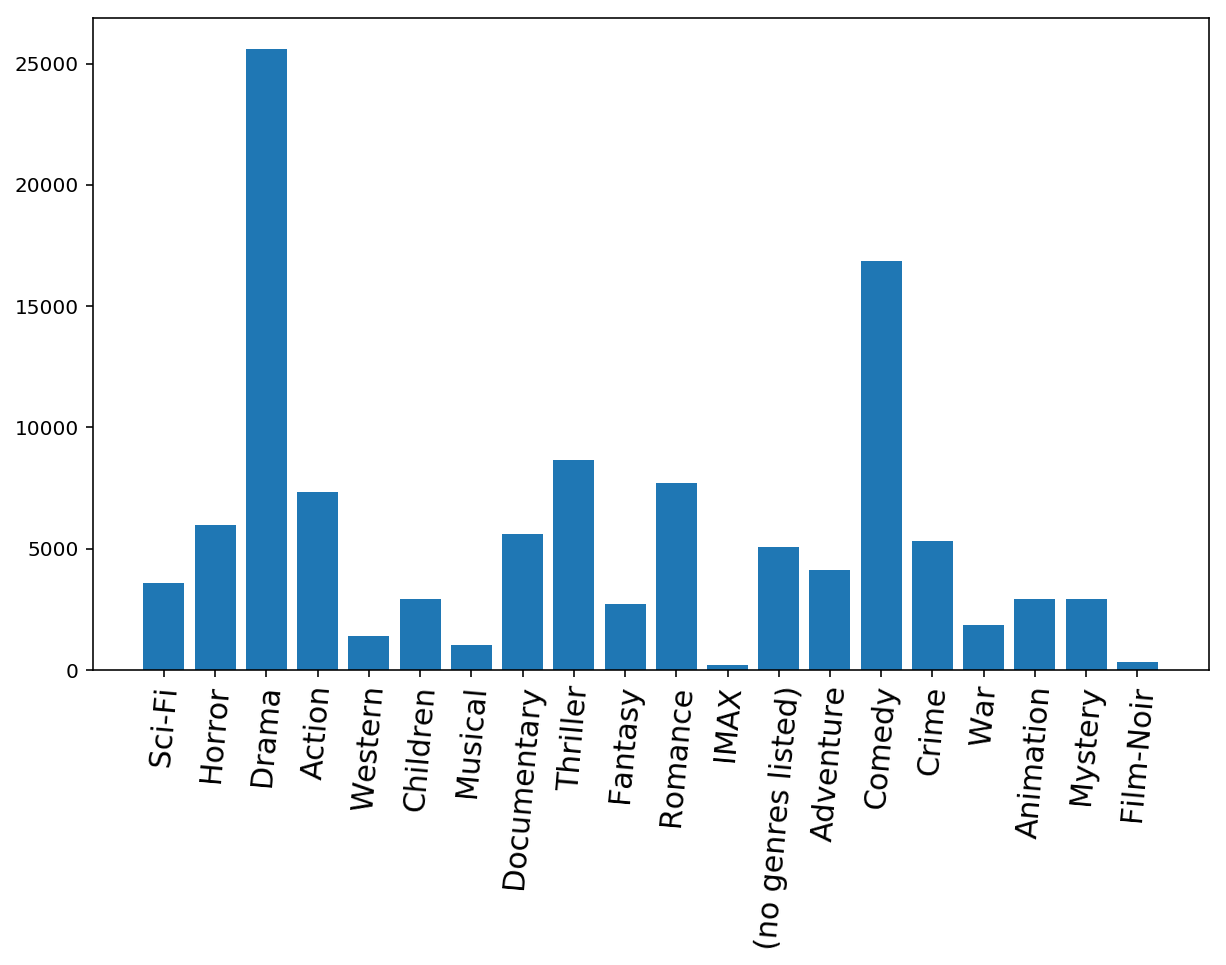

In [31]:
keys, values = zip(*genres)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [33]:
######################################
######### YOUR CODE HERE #############
######################################
links = sc.textFile(LINKS_PATH)
tmdb = sqlContext.read.json(TMDB_PATH).rdd


In [36]:
movies = sc.textFile(MOVIES_PATH)
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: arr[0])
movies.take(10)

[('1', ['1', 'Toy Story (1995)']),
 ('2', ['2', 'Jumanji (1995)']),
 ('3', ['3', 'Grumpier Old Men (1995)']),
 ('4', ['4', 'Waiting to Exhale (1995)']),
 ('5', ['5', 'Father of the Bride Part II (1995)']),
 ('6', ['6', 'Heat (1995)']),
 ('7', ['7', 'Sabrina (1995)']),
 ('8', ['8', 'Tom and Huck (1995)']),
 ('9', ['9', 'Sudden Death (1995)']),
 ('10', ['10', 'GoldenEye (1995)'])]

In [42]:
tmdb_movie_id = tmdb\
    .filter(lambda a: hasattr(a.casts, "cast") and 31 in [cast.id for cast in a.casts.cast])\
    .map(lambda a: a.id)\
    .keyBy(lambda ids: str(ids))

links_id = links\
    .map(lambda r: r.split(','))\
    .filter(lambda a: a[0].isdigit())\
    .map(lambda a: (a[0], a[2]))\
    .keyBy(lambda row: row[1])



In [45]:
tmdb_movie_id\
    .join(links_id)\
    .map(lambda a: a[1][1])\
    .keyBy(lambda a: a[0])\
    .join(movies)\
    .map(lambda a: a[1][1][1])\
    .collect()

['Cast Away (2000)',
 '"Man with One Red Shoe',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 'Catch Me If You Can (2002)',
 'Extremely Loud and Incredibly Close (2011)',
 'Ithaca (2015)',
 'Toy Story of Terror (2013)',
 '"Terminal',
 "Defying the Nazis: The Sharps' War (2016)",
 'Volunteers (1985)',
 'Toy Story (1995)',
 '"\'burbs',
 'Road to Perdition (2002)',
 'Saving Private Ryan (1998)',
 'Toy Story Toons: Small Fry (2011)',
 '"Green Mile',
 'Angels & Demons (2009)',
 'Cars (2006)',
 'Nothing in Common (1986)',
 'Splash (1984)',
 'Shooting War (2000)',
 'Everything Is Copy (2015)',
 'Mazes and Monsters (1982)',
 'Sully (2016)',
 '"Celluloid Closet',
 'Apollo 13 (1995)',
 '"The Mayo Clinic',
 'Inferno (2016)',
 'Radio Flyer (1992)',
 'Joe Versus the Volcano (1990)',
 'And the Oscar Goes To... (2014)',
 'Killing Lincoln (2013)',
 'The Circle (2016)',
 '"Pixar Story',
 'Elvis Has Left the Building (2004)',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'Bachelor P

In [46]:
cast_id = tmdb\
    .filter(lambda a: hasattr(a.casts, "cast"))\
    .flatMap(lambda a: [(cast.name, 1) for cast in a.casts.cast])\
    .reduceByKey(lambda a, b: a + b)\
    .sortBy(lambda a : a[1], ascending=False)
cast_id.take(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 133)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [47]:
######################################
######### YOUR CODE HERE #############
######################################

import numpy as np                     
genres = np.array(
    tmdb\
    .filter(lambda a: a.genres and a.release_date)\
    .flatMap(lambda a : [genre.name for genre in a.genres])\
    .distinct()\
    .collect()
)

In [49]:
time = np.array(tmdb\
    .filter(lambda a: a.genres and a.release_date)\
    .map(lambda a : (int(a.release_date[:4]), np.sum(np.array([genre.name for genre in a.genres]).reshape(-1, 1) == genres, axis = 0)))\
    .reduceByKey(lambda a, b : a + b)\
    .mapValues(lambda a : a / np.sum(a))\
    .sortBy(lambda a: a[0])\
    .collect())

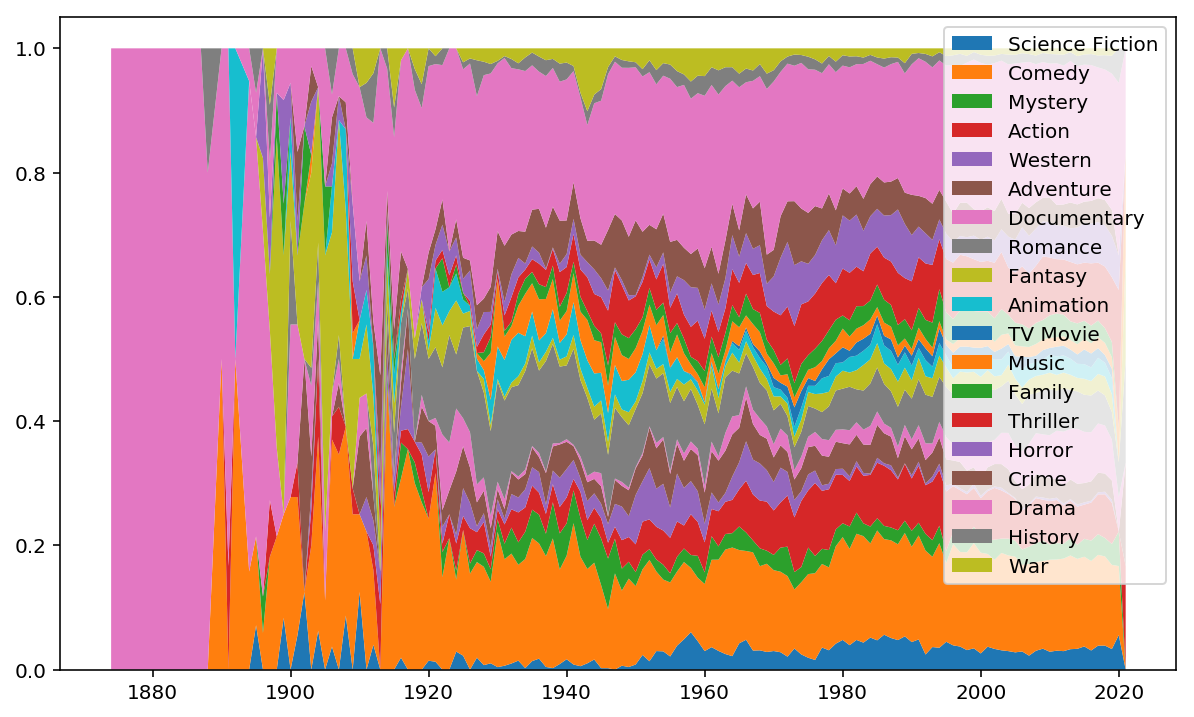

In [50]:

x = time[:, 0].astype('int')
y = np.vstack(time[:, 1]).T

plt.figure(figsize = (10, 6))
plt.stackplot(x, *y, labels = genres)
plt.legend()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [39]:
######################################
######### YOUR CODE HERE #############
######################################
ROI = tmdb\
    .filter(lambda row: row.genres)\
    .flatMap(lambda row : [(genre.name, (row.revenue, row.budget)) for genre in row.genres])\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .mapValues(lambda a: a[0]/a[1])\
    .sortBy(lambda a: a[1])

ROI.take(10)


[('TV Movie', 0.24821777220190697),
 ('Western', 1.6299865996133251),
 ('History', 1.724512038213056),
 ('War', 2.0896055972378202),
 ('Crime', 2.3251750722843862),
 ('Thriller', 2.3660134898597756),
 ('Drama', 2.3805028057282005),
 ('Mystery', 2.421177738632568),
 ('Action', 2.731823383674337),
 ('Horror', 2.760497527872953)]

In [40]:
ROI=ROI.collect()

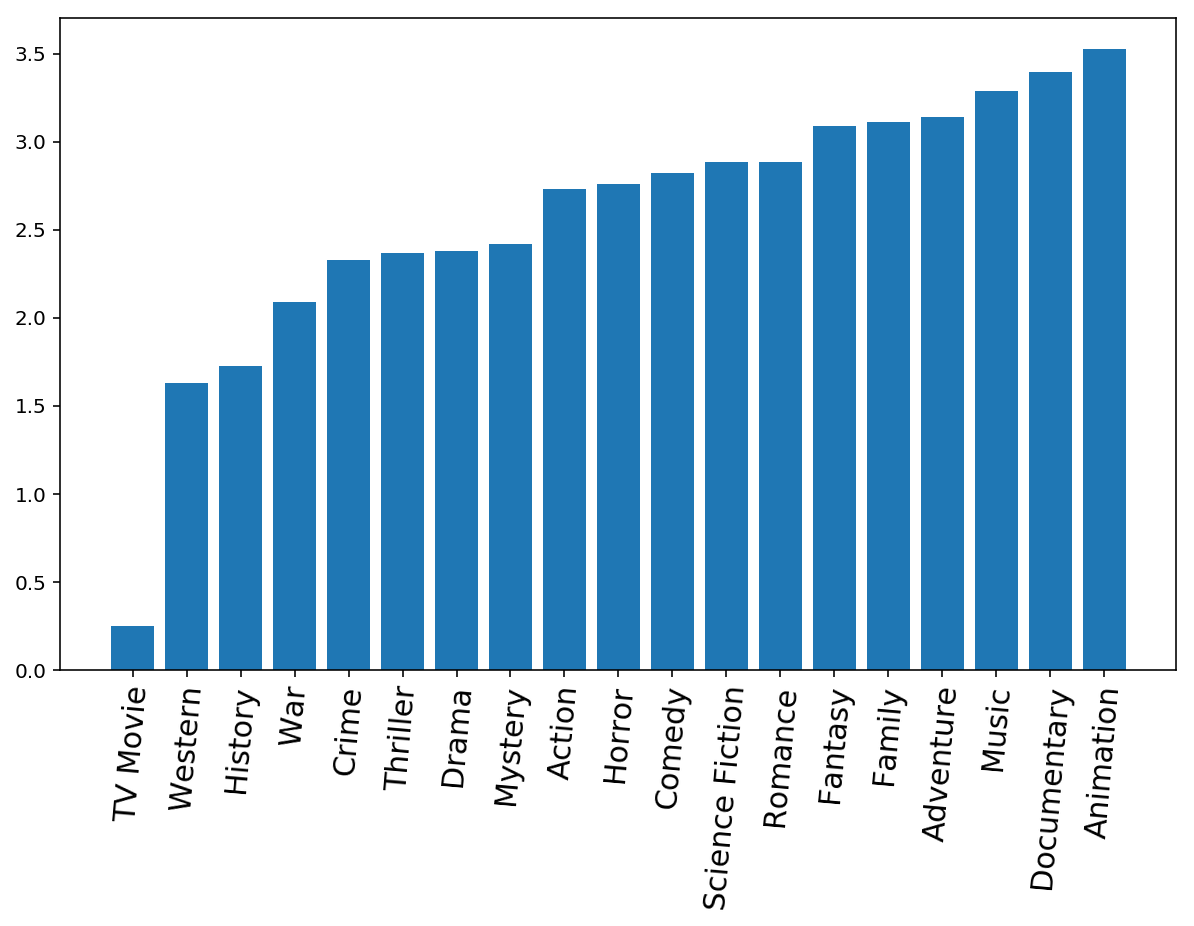

In [41]:
keys, values = zip(*ROI)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()